<a href="https://colab.research.google.com/github/vmatiasw/Algoritmos-y-estructuras-de-datos-2-FAMAF/blob/main/Parcial3_2024_06_13.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [253]:
from numpy import sqrt, inf, log, where, asarray
from scipy.special import erf, comb
from scipy.stats import kstest, chi2, norm
from scipy.integrate import quad
from random import random, seed
from pandas import DataFrame

# Ejercicio 2

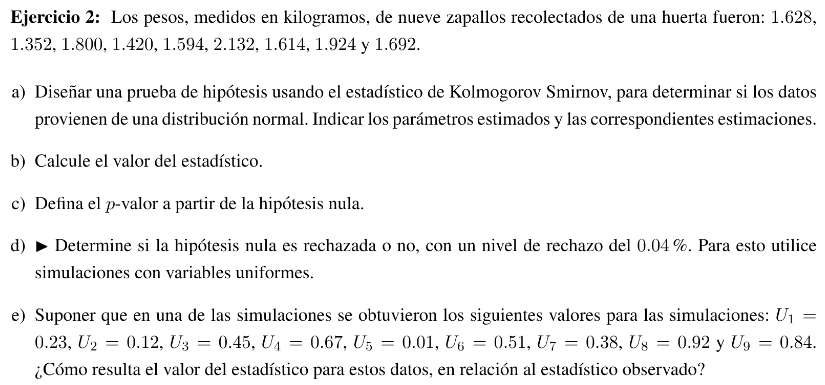

## A

In [254]:
MUESTRA = [1.628, 1.352, 1.8, 1.42, 1.594, 2.132, 1.614, 1.924, 1.692]

MEDIA_MUESTRAL = sum(MUESTRA) / len(MUESTRA)

print(MEDIA_MUESTRAL)

1.6840000000000002


In [255]:
VARIANZA_MUESTRAl = sum((x - MEDIA_MUESTRAL) ** 2 for x in MUESTRA) / (len(MUESTRA) - 1)
DESVIACION_ESTANDAR_MUESTRAL = sqrt(VARIANZA_MUESTRAl)
print(DESVIACION_ESTANDAR_MUESTRAL)

0.2418367217773182


## B

In [256]:
class DistNormal:
    def __init__(self, mu=0.0, sigma=1.0): self.mu, self.sigma = mu, sigma
    def fda(self, x): return 0.5 * (1 + erf((x - self.mu) / (self.sigma * sqrt(2))))
    def simular(self):
        while True:
            y1, y2 = -log(1 - random()), -log(1 - random()) # = DistExponencial(l=1).muestrear(2)
            if y2 >= (y1 - 1)**2 / 2:
                signo = 1 if random() < 0.5 else -1
                return signo * y1 * self.sigma + self.mu
    def muestrear(self, n): return [self.simular() for _ in range(n)]

normal_estimada = DistNormal(mu=MEDIA_MUESTRAL, sigma=DESVIACION_ESTANDAR_MUESTRAL)

In [257]:
def estadistico_KS(muestra, F_fda):
    tamano_muestra = len(muestra)
    muestra_ordenada = sorted(muestra)
    D_max =  -inf

    for j, y in enumerate(muestra_ordenada, start=1):
        F_y = F_fda(y)
        D_minus = F_y - (j - 1) / tamano_muestra
        D_plus = j / tamano_muestra - F_y
        D_max = max(D_max, D_minus, D_plus)

    return D_max

print(f"d estadistico: {estadistico_KS(MUESTRA, normal_estimada.fda)}")

d estadistico: 0.15347199452116866


## C

H0 = la muestra proviene de alguna distribucion normal

p-valor = umbral para rechazar H0. Si alpha <= p-valor, entonces se rechaza H0

## D

In [258]:
N_SIM = 10000

class DistU:
    def fda(self, x): return x
    def muestrear(self, n): return [random() for _ in range(n)]
uniforme = DistU()

def estimar_Pvalor_KS(muestra_empirica, F_Dist):
    tam_muestra = len(muestra_empirica)
    d_empirico = estadistico_KS(muestra_empirica, F_Dist.fda)
    cuenta = 0
    for _ in range(N_SIM):
        # F_muestra = F_Dist.muestrear(tam_muestra)
        # d_sim = estadistico_KS(F_muestra, F_Dist.fda)
        U_muestra = uniforme.muestrear(tam_muestra)
        d_sim = estadistico_KS(U_muestra, uniforme.fda)
        cuenta += d_empirico <= d_sim

    return cuenta / N_SIM

seed(1)
p_valor_estimado = estimar_Pvalor_KS(MUESTRA, normal_estimada)
print(f"P-valor estimado: {p_valor_estimado}")

P-valor estimado: 0.9626


por lo tanto no se rechaza H0 con un nivel de rechazo $\alpha = 0.004$

## E

In [259]:
U_MUESTRA = [0.23, 0.12, 0.45, 0.67, 0.01, 0.51, 0.38, 0.92, 0.84]
print(f"D estadistico simulado: {estadistico_KS(U_MUESTRA, uniforme.fda)}")

D estadistico simulado: 0.15666666666666662


## chequeo

In [260]:
d_estimado = estadistico_KS(MUESTRA, normal_estimada.fda)
p_valor_estimado = estimar_Pvalor_KS(MUESTRA, normal_estimada)

print(f"D estimado: {d_estimado}")
print(f"P-valor estimado: {p_valor_estimado}")

D estimado: 0.15347199452116866
P-valor estimado: 0.9625


In [261]:
d_correcto, p_valor_correcto = kstest(MUESTRA, cdf=normal_estimada.fda)
print(f"D correcto: {d_correcto}")
print(f"P-valor correcto: {p_valor_correcto}")

D correcto: 0.15347199452116866
P-valor correcto: 0.9629272457300383


In [262]:
d_correcto, p_valor_correcto = kstest(MUESTRA, 'norm', args=(MEDIA_MUESTRAL, DESVIACION_ESTANDAR_MUESTRAL))
print(f"D correcto: {d_correcto}")
print(f"P-valor correcto: {p_valor_correcto}")

D correcto: 0.15347199452116866
P-valor correcto: 0.9629272457300383


# Ejercicio 3

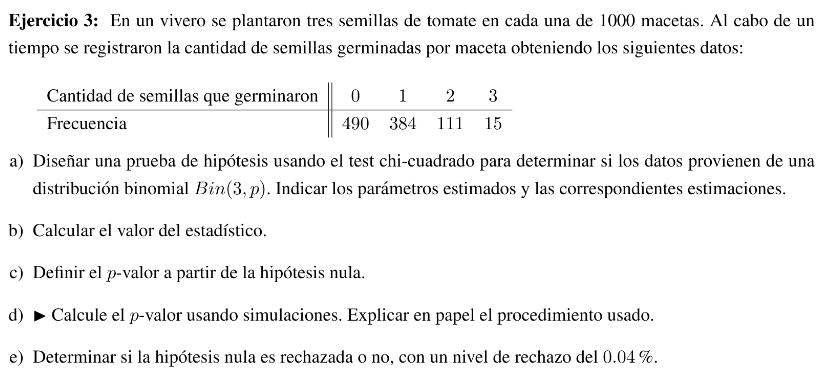

In [263]:
VALORES = [0, 1, 2, 3]
FRECUENCIAS = [490, 384, 111, 15]

## A

In [264]:
def estimador_p_binomial(frecuencias, valores=VALORES, n=3):
    media_muestral = sum(asarray(frecuencias) * asarray(valores)) / sum(frecuencias)
    return media_muestral / n

P_ESTIMADO = estimador_p_binomial(FRECUENCIAS)
P_ESTIMADO

np.float64(0.217)

In [265]:
class DistBinomial:
    def __init__(self, n, p): self.n, self.p = n, p
    def fpm(self, x): return where((0 <= x) & (x <= self.n), comb(self.n, x) * self.p**x * (1 - self.p)**(self.n - x), 0)
    def simular(self):
        n, p = self.n, self.p
        odds = p / (1 - p)
        prob = (1 - p)**n
        Fx, x = prob, 0
        u = random()
        while u >= Fx:
            prob *= odds * (n - x) / (x + 1)
            Fx += prob
            x += 1
        return x
    def muestrear(self, m): return [self.simular() for _ in range(m)]
binomial = DistBinomial(3, P_ESTIMADO)

## B

In [266]:
PROBABILIDADES_ESPERADAS = [binomial.fpm(x) for x in VALORES]
PROBABILIDADES_ESPERADAS

[array(0.48004869), array(0.39912094), array(0.11061206), array(0.01021831)]

In [267]:
def estadistico_chi2(frecs_empiricas, probs_esperadas, tamano_muestra):
    n = tamano_muestra
    N = asarray(frecs_empiricas)
    p = asarray(probs_esperadas)
    return sum((N - n*p) ** 2 / n*p)

# Cálculo del p-valor
k_grados_libertad = len(VALORES) - 1 - 1
t_estadistico_observado = estadistico_chi2(FRECUENCIAS, PROBABILIDADES_ESPERADAS, sum(FRECUENCIAS))
p_valor = chi2.sf(t_estadistico_observado, df=k_grados_libertad)

# Resultado final
print(f"p-valor = P(chi²_{k_grados_libertad} ≥ {t_estadistico_observado}) = {p_valor}")

p-valor = P(chi²_2 ≥ 0.1390449752185273) = 0.9328391558262472


## C

## D

In [268]:
N_SIM = 10_000

def estimar_Pvalor_conF(F_dist, valores, t_empirico, tamano_muestra):
  cuenta = 0
  for _ in range(N_SIM):
    muestra = F_dist.muestrear(tamano_muestra)
    frecuencias = [muestra.count(x) for x in valores]

    p_estimado = estimador_p_binomial(frecuencias)
    dist_estimada = DistBinomial(3, p_estimado)
    probs_sim = [dist_estimada.fpm(x) for x in valores]

    t_muestra = estadistico_chi2(frecuencias, probs_sim, tamano_muestra)
    cuenta += t_empirico <= t_muestra
  return cuenta / N_SIM

seed(1)
print(f"p-valor estimado = {estimar_Pvalor_conF(binomial, VALORES, t_estadistico_observado, sum(FRECUENCIAS))}")

p-valor estimado = 0.2686


In [ ]:
def generar_frecuencias(tamano_muestra, probs_esperadas):
    Ns = []
    anterior_Fv = 0 # F(anterior v)
    anterior_sum_Ns = 0
    for prob_v in probs_esperadas[:-1]:
        binomial_frec = DistBinomial(tamano_muestra - anterior_sum_Ns, prob_v / (1 - anterior_Fv))
        N_v = binomial_frec.simular()
        Ns.append(N_v)
        anterior_Fv += prob_v
        anterior_sum_Ns += N_v
    Ns.append(tamano_muestra - anterior_sum_Ns)
    return Ns

def estimar_Pvalor_conFrec(valores, probs_esperadas, t_empirico, tamano_muestra):
  cuenta = 0
  for _ in range(N_SIM):
    frecuencias = generar_frecuencias(tamano_muestra, probs_esperadas)

    p_estimado = estimador_p_binomial(frecuencias)
    binomial_sim = DistBinomial(3, p_estimado)
    t_probs = [binomial_sim.fpm(x) for x in valores]

    t_muestra = estadistico_chi2(frecuencias, t_probs, tamano_muestra)
    cuenta += t_empirico <= t_muestra
  return cuenta / N_SIM

seed(1)
print(f"p-valor estimado = {estimar_Pvalor_conFrec(VALORES, PROBABILIDADES_ESPERADAS, t_estadistico_observado, sum(FRECUENCIAS))}")

## E
H0 se rechaza ya que $\alpha = 0.004 <$ p-valor muy cercano a 0

# Ejercicio 4

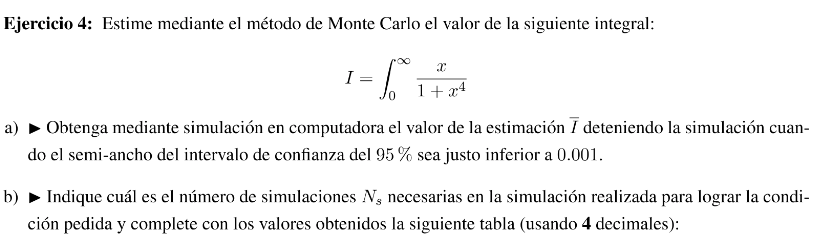

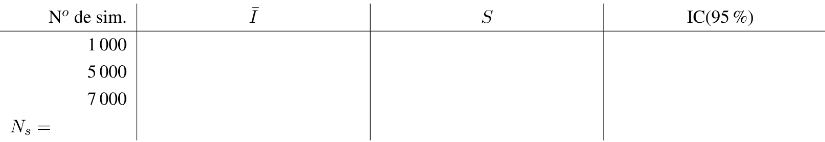

In [ ]:
def integrando(x):
    return x / (1 + x**4)

def integral_0inf(x):
    return integrando(x)

def integral_01(x):
    return integrando(1/x - 1) / x**2

print(f"resultado esperado: {quad(integral_0inf, 0, inf)[0]}")
print(f"resultado esperado: {quad(integral_01, 0, 1)[0]}")

In [ ]:
def estimar_media_muestral_con_IC(experimento, long_interv, z_alpha_2):
    seed(1)
    error_estandar = long_interv / (2 * z_alpha_2)
    media = experimento()
    Scuad, n, intervalo = 0, 1, ()
    resultados = []

    while n <= 100 or sqrt(Scuad/n) > error_estandar:
         n += 1
         muestra = experimento()
         media_anterior = media

         media += (muestra - media_anterior) / n
         Scuad = Scuad * (1 - 1 /(n-1)) + n*(media - media_anterior)**2
         intervalo = (
             media - z_alpha_2*sqrt(Scuad / n),
             media + z_alpha_2*sqrt(Scuad / n))

         if n in {1000, 5000, 7000}:
            resultados.append((n, media, Scuad, intervalo))
    resultados.append((n, media, Scuad, intervalo))
    return resultados


confianza = 0.95
alpha = 1 - confianza
z_alpha_2 = abs(norm.ppf(alpha/2))

semi_ancho = 0.001
long_interv = semi_ancho * 2
seed(1)
resultados = estimar_media_muestral_con_IC(lambda: integral_01(random()), long_interv, z_alpha_2)

In [ ]:
def crear_cuadro_descriptivo(results, decimales=4):
    ns, medias, Scuads, intervalos = zip(*results)

    df = DataFrame({
        "n": ns,
        "Integral": medias,
        "Scuad": Scuads,
        "S": sqrt(Scuads),
        "IC (95%)": [(round(i[0], decimales), round(i[1], decimales)) for i in intervalos],
        "Long. IC": [i[1] - i[0] for i in intervalos]
    })

    return df.round(decimales)

df_1 = crear_cuadro_descriptivo(resultados)
df_1